DataFrame columns: ['customer_id', 'age', 'gender', 'country', 'annual_income', 'spending_score', 'num_purchases', 'avg_purchase_value', 'membership_years', 'website_visits_per_month', 'cart_abandon_rate', 'churned', 'feedback_text', 'last_purchase_date']


/tmp/ipython-input-339148050.py:16: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'])


MAE: 0.004094949999998374
RMSE: 0.009540020702284782


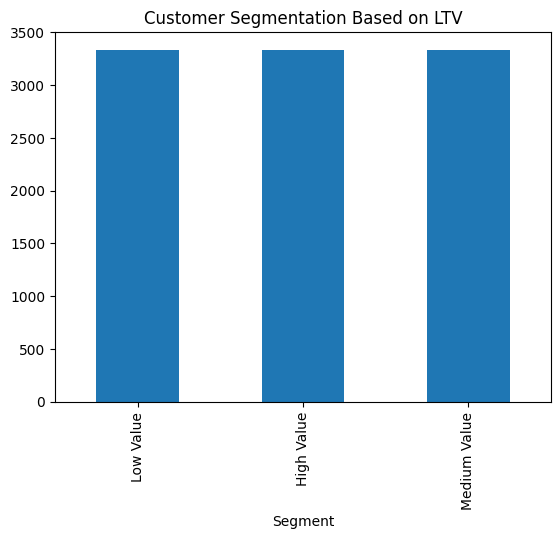

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv("/content/customer_transactions (1).csv")

# Print columns to debug KeyError
print("DataFrame columns:", df.columns.tolist())

# Convert date
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'])

# Feature engineering
latest_date = df['last_purchase_date'].max()

rfm = df.groupby('customer_id').agg({
    'last_purchase_date': lambda x: (latest_date - x.max()).days,
    'customer_id': 'count',
    'avg_purchase_value': 'mean' # Assuming 'amount' is 'avg_purchase_value'
})

rfm.columns = ['Recency', 'Frequency', 'AOV']
rfm.reset_index(inplace=True)

# LTV
rfm['LTV'] = rfm['Frequency'] * rfm['AOV']

# Model data
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['LTV']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Predict LTV
rfm['Predicted_LTV'] = model.predict(X)

# Segment customers
rfm['Segment'] = pd.qcut(
    rfm['Predicted_LTV'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

# Visualization
rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segmentation Based on LTV")
plt.show()

# Save output
rfm.to_csv("Final_LTV_Predictions.csv", index=False)